In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

TRAINDIR = 'faces/train' # directory where we store our data
TESTDIR = 'faces/test' # directory where we store our testing data

IMG_Y_SIZE = 112
IMG_X_SIZE = 92
names = os.listdir(TRAINDIR)
NUM_NAMES = len(names)

## Load the training data

In [2]:
X = []
y = []

for name in names:
    name_num = names.index(name)
    for img in os.listdir(f"{TRAINDIR}/{name}"):
        img_array = cv2.imread(f"{TRAINDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
        new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
        X.append(new_array)
        y.append(name_num)


# Convert to NumPy arrays
X = np.array(X).reshape(-1, 1, IMG_Y_SIZE, IMG_X_SIZE)  # PyTorch expects (N, C, H, W)
y = np.array(y)

X = X / 255

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)


## Load the testing data

In [3]:
XT = []
yt = []

for name in names:
    name_num = names.index(name)
    for img in os.listdir(f"{TESTDIR}/{name}"):
        img_array = cv2.imread(f"{TESTDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
        new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
        XT.append(new_array)
        yt.append(name_num)

# Convert to NumPy arrays
XT = np.array(XT).reshape(-1, 1, IMG_Y_SIZE, IMG_X_SIZE)  # PyTorch expects (N, C, H, W)
yt = np.array(yt)

XT = XT / 255

# Convert to PyTorch tensors
XT = torch.tensor(XT, dtype=torch.float32)
yt = torch.tensor(yt, dtype=torch.long)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:

train_dataset = TensorDataset(X, y)
test_dataset = TensorDataset(XT, yt)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [6]:

# Define the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=36, kernel_size=7)
        self.flatten = nn.Flatten()
        # Assuming valid padding: compute flattened size after conv
        conv_out_size = (IMG_X_SIZE - 6) * (IMG_Y_SIZE - 6) * 36
        self.fc1 = nn.Linear(conv_out_size, NUM_NAMES)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.fc1(x)
        return x

model = CNNModel()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
print(model)

CNNModel(
  (conv1): Conv2d(1, 36, kernel_size=(7, 7), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=328176, out_features=40, bias=True)
)


In [8]:
# train the model
EPOCHS = 7

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accuracy calculation (optional)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print epoch stats
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1/7, Loss: 660.9926, Accuracy: 21.11%
Epoch 2/7, Loss: 9.5121, Accuracy: 96.67%
Epoch 3/7, Loss: 0.5824, Accuracy: 99.72%
Epoch 4/7, Loss: 0.0782, Accuracy: 100.00%
Epoch 5/7, Loss: 0.0152, Accuracy: 100.00%
Epoch 6/7, Loss: 0.0095, Accuracy: 100.00%
Epoch 7/7, Loss: 0.0058, Accuracy: 100.00%


Decoding: s1


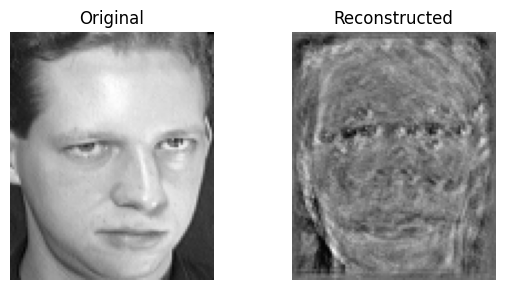

7.784063927829266e-05
Decoding: s10


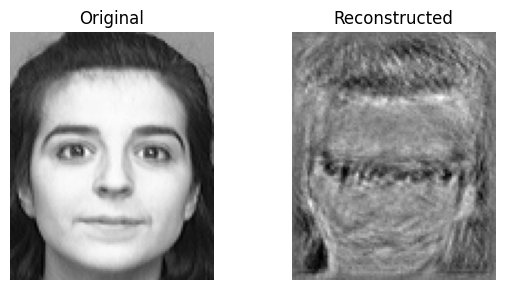

0.057989686727523804
Decoding: s11


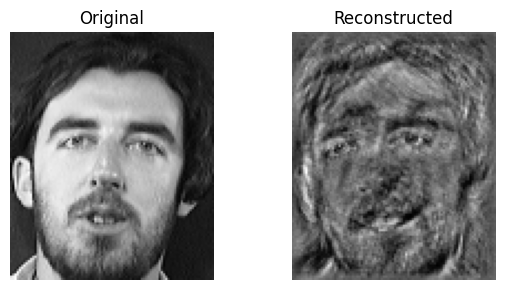

0.13869427144527435
Decoding: s12


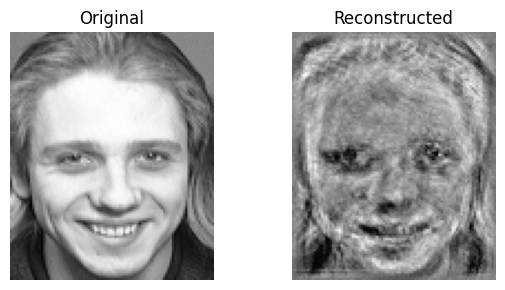

0.0015714927576482296
Decoding: s13


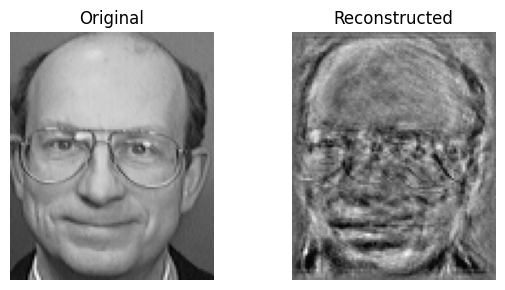

4.8040190449682996e-05
Decoding: s14


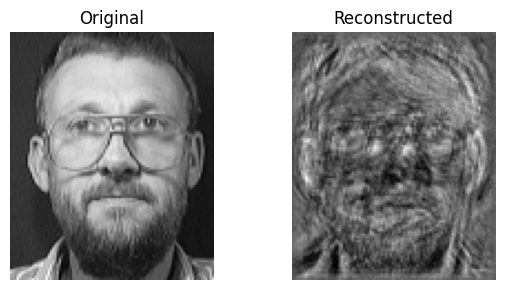

0.07529307901859283
Decoding: s15


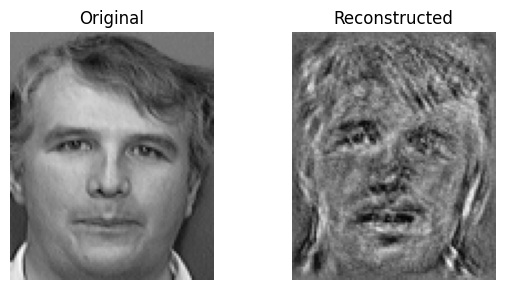

0.008753972128033638
Decoding: s16


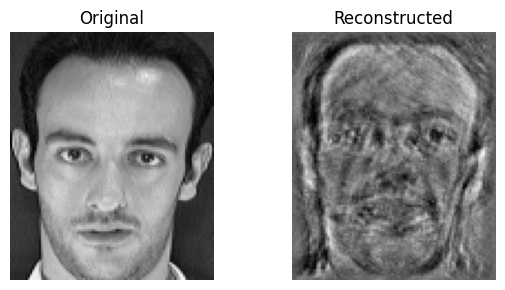

0.0025121578946709633
Decoding: s17


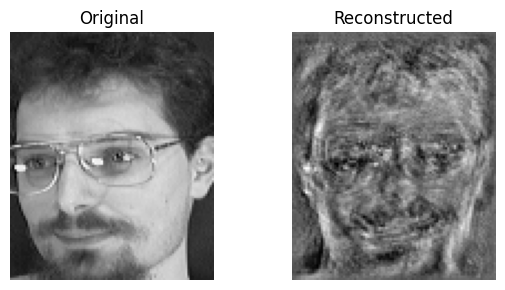

0.011838064529001713
Decoding: s18


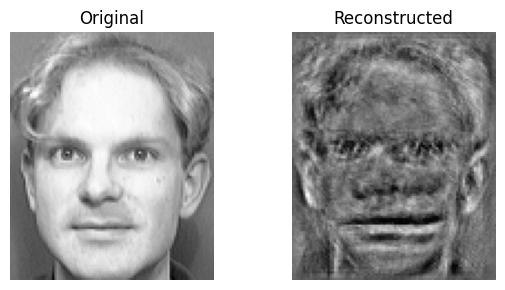

3.099436753473128e-06


In [ ]:

loss_fn = torch.nn.CrossEntropyLoss()

def inversion(model, img, learning_rate, label, best_loss):
    img.requires_grad_(True)  # Enable gradient tracking on input
    best_img = img.detach().clone()
    model.eval()

    output = model(img)
    loss = loss_fn(output, torch.tensor([label], dtype=torch.long))

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        # Gradient step
        img = img - learning_rate * img.grad
        img = torch.clamp(img, 0, 1)  # Assuming normalized images (0-1)

        # Add noise
        noise = torch.tensor(np.random.normal(loc=0.01, scale=0.001, size=img.shape), dtype=torch.float32)
        img = torch.clamp(img + noise, 0, 1)

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_img = img.clone()

    return best_img, best_loss

# Initialize blank image (shape: (1, 1, H, W))
black_image_tensor = torch.zeros((1, 1, IMG_Y_SIZE, IMG_X_SIZE), dtype=torch.float32)

# Reconstruct first 10 faces
for name_index in range(10):
    print("Decoding:", names[name_index])
    best_img = black_image_tensor.clone()
    best_loss = float('inf')
    for i in range(100):
        best_img, best_loss = inversion(model, best_img, 0.1, name_index, best_loss)

    _, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(XT[name_index].squeeze().cpu(), cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(best_img.squeeze().cpu(), cmap='gray')
    axs[1].set_title("Reconstructed")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()
    print(best_loss)

